# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera
based on the notebook Template

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
* [References](#references)

## Introduction: Business Problem <a name="introduction"></a>

### Background

With the boom in the entertainment industry and increase in collaboration between African countries, more East Africans have found themselves immigrating (temporarily or otherwise) to West Africa. Particularly looking at major cities like **Accra**, Ghana and **Lagos**, Nigeria. Focussing on academic and artistic young (*ages 18-35*) immigrants from **Nairobi**, Kenya; looking for similarities in recreation or to start an accessible restaurant with a feeling of home.

### Problem

This project aims to find **relatively similar neighborhoods**, that are **close to the city center**. Areas with a multi-cultural restaurant option might be highlighted. Note that although Lagos might be a major entertainment destination, things like the cost of living might also affect decision. Nairobi is an arbitrary East African country chosen for this project.

### Interest

Based on our target demographic and criteria specified, some neighborhoods will be selected. Their features will also be outlined for the stakeholders to choose the best location for their restaurant. This not only brings a homely feel to an otherwise foreign area, it also adds variety to the menu/restaurant options of the locals.


## Data <a name="data"></a>

The criteria set in the problem definition section identifies the following as decision influencers:
1. Similarity of neighborhoods
2. distance from city center
3. Cost of living

### Data Source
A base cost of living in these three cites can be comapred, and data scraped from **Numbeo** to get:
- [Nairobi vs Ghana](https://www.numbeo.com/cost-of-living/compare_cities.jsp?country1=Kenya&country2=Nigeria&city1=Nairobi&city2=Lagos&tracking=getDispatchComparison)
- [Nairobi vs Lagos](https://www.numbeo.com/cost-of-living/compare_cities.jsp?country1=Kenya&country2=Ghana&city1=Nairobi&city2=Accra)

All cost will be extracted in Kenyan shilling. Due to the small amount of data available on **Foursquare API** for these locations, the number of location types for a small set will be used to determine similarity. City center coordinates will be obtained.

### Data Collection and Data Cleaning
From the age group the assumption of a single person, renting an apartment away from the centre. To reduce the exttracted data, our initial search deals with a demographic with no dependents (*Based on population data, and general society structure this might not be the case*). These are just a few indicators, foodstuff prices were not extracted as they vary with location within cites.


With this in mind, indice difference along with the following shall be extracted:
* Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment
* Apartment (1 bedroom) Outside of Centre
* Fitness Club, Monthly Fee for 1 Adult
* Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)
* Monthly Pass (Regular Price)(**There has been an increase in fuel price in Nigeria, so this might not be a true representation**)
* Meal for 2 People, Mid-range Restaurant, Three-course
* Meal, Inexpensive Restaurant

Having outlined all necessary parameters that will be observed, data cleaning process was performed.

#### Nairobi vs Accra Cost of Living
In this section, the webscraping method to extract information will be set-up. Libraries imported, and function defined to create a general structure of how the *numbeo* cost of living data is extraced. The data frame will then be created for the Nairobi Accra comparison.

In [7]:
## Import Libraries
!pip install bs4
import pandas as pd
import requests
from bs4 import BeautifulSoup # for webscraping

     |████████████████████████████████| 122kB 5.9MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4


###### Webscraping the Numbeo Nairobi vs Accra page

In [36]:
# Use webscraping for data
url_GHK = 'https://www.numbeo.com/cost-of-living/compare_cities.jsp?country1=Kenya&country2=Ghana&city1=Nairobi&city2=Accra'
html_data = requests.get(url_GHK).text
# bea
beautiful_soup = BeautifulSoup(html_data, "html5lib")
#beautiful_soup

As these will occur twice, functions were defined for processing ease.

In [37]:
### Indice Extraction
def getIndice(indice, soupTables, indlist, compCountry):
    NairobiDiff= "Nairobi"+ compCountry + "(%)"   
    compCountry = compCountry + "(KSh)"
    livingCost = pd.DataFrame(columns=["Indicator", "Nairobi (KSh)", compCountry, NairobiDiff])

    for row in soupTables[indice].find("tbody").find_all("tr"):
        col = row.find_all("td")
        # Loop through indicator cost list
        for indicator in indlist:
            if (indicator in str(col)):
                ind = col[0].text
                nai = col[1].text.strip('\n').split("(")[0].strip("KSh").replace(',', "")
                comp = col[2].text.strip('\n').split("(")[0].strip("KSh").replace(',', "")
                compDiff = col[3].text.strip('\n').strip("%").replace('\n', "")
                livingCost = livingCost.append({"Indicator":ind, "Nairobi (KSh)":float(nai), compCountry : float(comp), NairobiDiff : float(compDiff)}, ignore_index=True)
    
    ### Find the total cost of Living
    ind = "TOTAL"
    nai = livingCost["Nairobi (KSh)"].sum()
    comp = livingCost[compCountry].sum()
    compDiff = 100 * (comp-nai)/nai # Finding the percent difference
    livingCost = livingCost.append({"Indicator":ind, "Nairobi (KSh)":float(nai), compCountry : float(comp), NairobiDiff : float(compDiff)}, ignore_index=True)
    
    return livingCost



Extract Data and save in dataframe

In [38]:
#Using beautiful soup to extract data into table
# New dataframe
costIndicators= ['Basic (Electricity, Heating, Cooling, Water, Garbage) for 915 sq ft Apartment', 'Apartment (1 bedroom) Outside of Centre', 'Fitness Club, Monthly Fee for 1 Adult', 'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)', 'Monthly Pass (Regular Price)', 'Meal for 2 People, Mid-range Restaurant, Three-course', 'Meal, Inexpensive Restaurant']
tables = beautiful_soup.find_all('table')

for index,table in enumerate(tables):
    if ("Indices Difference" in str(table)):
        indice = index
    elif ("highlighted_th prices" in str(table)):
        LC = index

In [39]:
# # PRINT OUT INDICE ANALYSIS
print("The Overall indicator differences for both are as follows:")
for row in tables[indice].find("tbody").find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        print(col[0].text)

The Overall indicator differences for both are as follows:
Consumer Prices in Accra are 13.91% higher than in Nairobi (without rent)
Consumer Prices Including Rent in Accra are 24.17% higher than in Nairobi
Rent Prices in Accra are 56.68% higher than in Nairobi
Restaurant Prices in Accra are 5.74% higher than in Nairobi
Groceries Prices in Accra are 28.42% higher than in Nairobi
Local Purchasing Power in Accra is 22.16% lower than in Nairobi


In [40]:
### DATA FRAME WITH SPECIFIC LIVING COSTS.
country = "Accra"
LivingCostGH= getIndice(LC, tables, costIndicators, country)
LivingCostGH.head()

,Indicator,Nairobi (KSh),Accra(KSh),NairobiAccra(%)
0,"Meal, Inexpensive Restaurant",500.00,554.51,10.90
1,"Meal for 2 People, Mid-range Restaurant, Three...",3500.00,3824.19,9.26
2,Monthly Pass (Regular Price),3489.13,3346.17,-4.10
3,"Basic (Electricity, Heating, Cooling, Water, G...",4348.98,8237.95,89.42
4,"Internet (60 Mbps or More, Unlimited Data, Cab...",6266.63,6028.99,-3.79


#### Nairobi vs Lagos Cost of Living
Following the resulting dataframe with the Ghana comparison, a similar process will be followed to create a Nairobi/Lagos comparison dataframe. The extracted data will then be showcased as a combined table.

Webscrapping

In [41]:
# Use webscraping for data
url_NGK = 'https://www.numbeo.com/cost-of-living/compare_cities.jsp?country1=Kenya&country2=Nigeria&city1=Nairobi&city2=Lagos&tracking=getDispatchComparison'
html_data = requests.get(url_NGK).text
# bea
beautiful_soup = BeautifulSoup(html_data, "html5lib")
#beautiful_soup

Extract Data and save in DataFrame

In [42]:
#Using beautiful soup to extract data into table
# New dataframe
costIndicators= ['Basic (Electricity, Heating, Cooling, Water, Garbage)', 'Apartment (1 bedroom) Outside of Centre', 'Fitness Club, Monthly Fee for 1 Adult', 'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)', 'Monthly Pass (Regular Price)', 'Meal for 2 People, Mid-range Restaurant, Three-course', 'Meal, Inexpensive Restaurant']
tables = beautiful_soup.find_all('table')

for index,table in enumerate(tables):
    if ("Indices Difference" in str(table)):
        indice = index
    elif ("highlighted_th prices" in str(table)):
        LC = index

In [43]:
# # PRINT OUT INDICE ANALYSIS
print("The Overall indicator differences for both are as follows:")
for row in tables[indice].find("tbody").find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        print(col[0].text)

The Overall indicator differences for both are as follows:
Consumer Prices in Lagos are 6.01% lower than in Nairobi (without rent)
Consumer Prices Including Rent in Lagos are 53.28% higher than in Nairobi
Rent Prices in Lagos are 241.09% higher than in Nairobi
Restaurant Prices in Lagos are 14.14% lower than in Nairobi
Groceries Prices in Lagos are 7.20% higher than in Nairobi
Local Purchasing Power in Lagos is 59.00% lower than in Nairobi


In [44]:
### DATA FRAME WITH SPECIFIC LIVING COSTS.
country = "Lagos"
LivingCostNG= getIndice(LC, tables, costIndicators, country)
LivingCostNG.head()

,Indicator,Nairobi (KSh),Lagos(KSh),NairobiLagos(%)
0,"Meal, Inexpensive Restaurant",500.00,267.05,-46.59
1,"Meal for 2 People, Mid-range Restaurant, Three...",3500.00,4330.49,23.73
2,Monthly Pass (Regular Price),3489.13,2886.99,-17.26
3,"Basic (Electricity, Heating, Cooling, Water, G...",4348.98,3336.70,-23.28
4,"Internet (60 Mbps or More, Unlimited Data, Cab...",6266.63,4575.36,-26.99


Merging the two dataframes and reating a total row for the summation of the city living cots:

In [45]:
livingCost = LivingCostNG.join(LivingCostGH.set_index(['Indicator', 'Nairobi (KSh)']), on = ['Indicator', 'Nairobi (KSh)'])
livingCost

,Indicator,Nairobi (KSh),Lagos(KSh),NairobiLagos(%),Accra(KSh),NairobiAccra(%)
0,"Meal, Inexpensive Restaurant",500.00,267.05,-46.590000,554.51,10.900000
1,"Meal for 2 People, Mid-range Restaurant, Three...",3500.00,4330.49,23.730000,3824.19,9.260000
2,Monthly Pass (Regular Price),3489.13,2886.99,-17.260000,3346.17,-4.100000
3,"Basic (Electricity, Heating, Cooling, Water, G...",4348.98,3336.70,-23.280000,8237.95,89.420000
4,"Internet (60 Mbps or More, Unlimited Data, Cab...",6266.63,4575.36,-26.990000,6028.99,-3.790000
5,"Fitness Club, Monthly Fee for 1 Adult",5310.34,5081.10,-4.320000,6596.74,24.220000
6,Apartment (1 bedroom) Outside of Centre,19281.25,75886.62,293.580000,11559.50,-40.050000
7,TOTAL,42696.33,96364.31,125.696939,40148.05,-5.968382


##### Getting venues from each city
Using Foursquare API, restaurant and venue information will be obtained foe Nairobi, Accra and Lagos. Sub-category list of restaurants will also be filtered.

In [1]:
# Import libraries
import random # library for random number generation


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 112kB 4.6MB/s eta 0:00:01
Folium installed
Libraries imported.


Focussing on entertainment and recreation only, therefore places of worship, shopping centers and other areas might not be explicitly searched for. The following categories are of interest:

* Arts & Entertainment ('4d4b7104d754a06370d81259')
* Event ('4d4b7105d754a06373d81259')
* Food ('4d4b7105d754a06374d81259')
* Nightlife Spot ('4d4b7105d754a06376d81259')
* Outdoors & Recreation ('4d4b7105d754a06377d81259')
* Food ('4d4b7105d754a06374d81259')

For ease of data collection and cleaning, two functions were created. This was to improve code efficiency as the foursquare method and maps will be executed for each city.

In [2]:
## This function creates a dataframe
def getVenues(url):
    # Send GET request
    results = requests.get(url).json()

    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)

    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']
        
        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

    return dataframe_filtered

## This function creates a map visualization
def cityMap(latitude, longitude, dataframe_filtered):

    venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

    # add a red circle marker to represent the Conrad Hotel
    folium.CircleMarker(
        [latitude, longitude],
        radius=10,
        color='red',
        popup='Conrad Hotel',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(venues_map)

    # add the Italian restaurants as blue circle markers
    for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color='blue',
            popup=label,
            fill = True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(venues_map)

# display map
    return venues_map


In [12]:
# @hidden_cell
CLIENT_ID = 'ZRUWJRSMGR2OOB3T42YFXDBAYDL2DG5UTCNUYE03LRULEOX4' # your Foursquare ID
CLIENT_SECRET = 'TQFD51WLSCINNLQTJBPFIIEGV4EU0R2AYG5OB5KTIFP4LWDN' # your Foursquare Secret
ACCESS_TOKEN = 'RDYYGMGCFCDVMKTG4S1OCAE1DMNVUBAWPRN55OZW13HHXIZL' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 500 # limit number of venues gotten

In [4]:
# Defining longitude and Latitude
latGH = 5.55602
latNG = 6.45407
latKE = -1.28333
lonGh = -0.1969
lonNG =3.39467
lonKE = 36.81667

Obtaining the 500 Accra venues within a 7500 m radius from the city centre (**this ensures that some parts of the outskirts is captured**) and plotting map:

In [20]:
# Define URL
longitude =lonGh
latitude = latGH
radius = 7500
url = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06373d81259,4d4b7105d754a06374d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06374d81259&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, radius, LIMIT)

# Get dataframe
accra_filtered =  getVenues(url)
accra_filtered.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,name,categories,address,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,crossStreet,postalCode,neighborhood,id
0,Mövenpick Ambassador Hotel,Hotel,Independence Ave.,5.554508,-0.202435,"[{'label': 'display', 'lat': 5.554507878285451...",635,GH,Accra,Greater Accra Region,Ghana,"[Independence Ave., Accra, Ghana]",NaN,NaN,NaN,4d6e9ee503cba35d478c24f5
1,Independence Square,Plaza,"Labadi Rd, Accra,",5.549360,-0.191886,"[{'label': 'display', 'lat': 5.549359545472855...",926,GH,Greater Accra,Ghana,Ghana,"[Labadi Rd, Accra,, Greater Accra, Ghana]",NaN,NaN,NaN,4d481ac7febd8eec6a661282
2,Osu,Other Great Outdoors,NaN,5.561015,-0.182378,"[{'label': 'display', 'lat': 5.56101511526483,...",1702,GH,Accra,Greater Accra Region,Ghana,"[Accra, Ghana]",NaN,NaN,NaN,4ef75aef29c268318966d2e1
3,Twist,Lounge,Abafun Crescent,5.571706,-0.167054,"[{'label': 'display', 'lat': 5.571706158277336...",3739,GH,Accra Metropolis,Greater Accra Region,Ghana,"[Abafun Crescent, Accra Metropolis, Ghana]",NaN,NaN,NaN,4baa8b4ff964a52047733ae3
4,Purple Pub,Bar,Ring Rd E,5.564984,-0.177914,"[{'label': 'display', 'lat': 5.564984451431374...",2328,GH,Accra,Greater Accra Region,Ghana,"[Ring Rd E, Accra, Ghana]",NaN,NaN,NaN,4cd1ffa17f56a1431217d8a6


In [21]:
accra_map= cityMap(latitude, longitude, accra_filtered)
accra_map

Obtaining the 500 Lagos venues within a 17,000 m radius from the city centre (**this ensures that some parts of the outskirts is captured**) and plotting map:

In [22]:
# Define URL
longitude =lonNG
latitude = latNG
radius = 17000
url = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06373d81259,4d4b7105d754a06374d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06374d81259&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, radius, LIMIT)

# Get dataframe
lagos_filtered =  getVenues(url)
lagos_filtered.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,name,categories,address,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Campos Stadium,Soccer Field,Campos Street,6.451098,3.394655,"[{'label': 'display', 'lat': 6.451097614372146...",330,NG,Lagos Island,Lagos,Nigeria,"[Campos Street, Lagos Island, Lagos, Nigeria]",NaN,NaN,50ba3f00e4b0c78358420c87
1,Eko Bridge,Bridge,Lagos,6.470538,3.371415,"[{'label': 'display', 'lat': 6.470537780438158...",3158,NG,Lagos,Lagos,Nigeria,"[Lagos, Lagos, Lagos, Nigeria]",NaN,NaN,4ef5c0e46c25c411e9dabc3b
2,Carter Bridge,Bridge,NaN,6.458465,3.393601,"[{'label': 'display', 'lat': 6.458464997800156...",503,NG,Lagos,Lagos,Nigeria,"[Lagos, Lagos, Nigeria]",NaN,NaN,515c4fcfe4b0e4dc2efcf0eb
3,Magodo GRA Suya Spot,BBQ Joint,Magodo GRA,6.619215,3.374753,"[{'label': 'display', 'lat': 6.619215251243562...",18515,NG,NaN,NaN,Nigeria,"[Magodo GRA, Nigeria]",NaN,NaN,4fac0c3ae4b0c811fe5c9266
4,Mega Chicken,African Restaurant,Agidingbi road,6.625926,3.353504,"[{'label': 'display', 'lat': 6.625926, 'lng': ...",19665,NG,Ikeja,Lagos,Nigeria,"[Agidingbi road, Ikeja, Lagos, Nigeria]",NaN,NaN,58a459d228680442688dd6f1


In [23]:
lagos_map= cityMap(latitude, longitude, lagos_filtered)
lagos_map

Obtaining the 500 Nairobi venues within a 14,900 m radius from the city centre (**this ensures that some parts of the outskirts is captured**) and plotting map:

In [24]:
# Define URL
longitude =lonKE
latitude = latKE
radius = 14900
url = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06373d81259,4d4b7105d754a06374d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06374d81259&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, radius, LIMIT)

# Get dataframe
nairobi_filtered =  getVenues(url)
nairobi_filtered.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


,name,categories,lat,lng,labeledLatLngs,distance,cc,neighborhood,city,state,country,formattedAddress,address,crossStreet,postalCode,id
0,Nairobi Safari Club Health Club,Gym,-1.280801,36.817412,"[{'label': 'display', 'lat': -1.28080122530391...",293,KE,Nairobi Central Business District,Nairobi,Nairobi,Kenya,"[Nairobi, Kenya]",NaN,NaN,NaN,50f4ebcae4b09bf7364fc914
1,GPO,Post Office,-1.286062,36.818532,"[{'label': 'display', 'lat': -1.28606233636563...",368,KE,City Square,Nairobi,Nairobi,Kenya,"[Kenyatta Avenue, Nairobi, Kenya]",Kenyatta Avenue,NaN,NaN,4e1970d87d8b8af913973f43
2,Mister Wok,Chinese Restaurant,-1.270387,36.816228,"[{'label': 'display', 'lat': -1.27038727522028...",1441,KE,NaN,Nairobi,Nairobi,Kenya,"[Forest Rd., Nairobi, Kenya]",Forest Rd.,NaN,NaN,4dc42fb1d164eb9c9fcee061
3,Winning Post,Lounge,-1.311537,36.742291,"[{'label': 'display', 'lat': -1.311537, 'lng':...",8853,KE,NaN,NaN,NaN,Kenya,[Kenya],NaN,NaN,NaN,5fe86cea45ffa21fad22d02e
4,Tibs ribs,BBQ Joint,-1.276540,36.874717,"[{'label': 'display', 'lat': -1.27654027401033...",6504,KE,NaN,Nairobi,Nairobi,Kenya,"[Nairobi, Kenya]",NaN,NaN,NaN,4ff5a41ee4b09751a6d63531


In [25]:
nairobi_map= cityMap(latitude, longitude, nairobi_filtered)
nairobi_map

Now that all the necessary data has been extracted and cleaned, the next step is to give a proper overview of how the data science methodlogy will be applied to this business project.

## Methodology <a name="methodology"></a>

Although insights on possible restaurant locations in a West african city can be gained from this project, it will focus on exploring the similarities in the recreational lives of the single independent Youths of these cities. Factoring in the overall cost of living as compared to a similarly popular East African city.

To achieve this, living cost information was extracted from **numbeo*** based on specified indicators. Some exploratory analysis was done, with charts for better visualization. The next step was the application of foursquare API, where **five hundred (500) venues from each city** was gotten.These venues are based on recreation and entertainment, therefore the appropriate categories were applied for filtering.

The maps and locations were rendered, analysis on this data would be performed by determining the number of venues that exist in each category. In this restaurants will also be filtered,although there is a lack of address and neighborhood data for some of extracted venues the few that exist will be compared.

*data has been collected from people Nairobi (129), Accra (57), Lagos (140) which is a small representation of overall living costs.

## Analysis <a name="analysis"></a>

In this section, basic exploratory data analysis will be used to gain additional information from the cleaned data.

### Living Cost Comparison

The table below shows a statistical analysis of the living cost data extracted from numbeo; the total calculated during initial cleaning was not included in this analysis.


In [52]:
livingCost[:7].describe() # Statistical analysis

,Nairobi (KSh),Lagos(KSh),NairobiLagos(%),Accra(KSh),NairobiAccra(%)
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,6099.475714,13766.330000,28.410000,5735.435714,12.265714
std,6088.231699,27438.538704,118.925782,3587.333361,39.516125
min,500.000000,267.050000,-46.590000,554.510000,-40.050000
25%,3494.565000,3111.845000,-25.135000,3585.180000,-3.945000
50%,4348.980000,4330.490000,-17.260000,6028.990000,9.260000
75%,5788.485000,4828.230000,9.705000,7417.345000,17.560000
max,19281.250000,75886.620000,293.580000,11559.500000,89.420000


A brief sidenote to highlight the exchange rate between *Kenyan Shilling* and *Ghanaian Cedis* is significantly lower than the exchange rate with *Nigerian Naira*. The table is generally nice as an initial overview, but more analysis is needed to gain more insight; and so graphs were created.

In [62]:
# Import necessary libraries
import numpy as np
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0


Matplotlib version:  3.3.3


In [54]:
# For ease set the index as Indicator
livingCost.set_index('Indicator')


,Nairobi (KSh),Lagos(KSh),NairobiLagos(%),Accra(KSh),NairobiAccra(%)
Indicator,,,,,
"Meal, Inexpensive Restaurant",500.00,267.05,-46.590000,554.51,10.900000
"Meal for 2 People, Mid-range Restaurant, Three-course",3500.00,4330.49,23.730000,3824.19,9.260000
Monthly Pass (Regular Price),3489.13,2886.99,-17.260000,3346.17,-4.100000
"Basic (Electricity, Heating, Cooling, Water, Garbage) for 915 sq ft Apartment",4348.98,3336.70,-23.280000,8237.95,89.420000
"Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)",6266.63,4575.36,-26.990000,6028.99,-3.790000
"Fitness Club, Monthly Fee for 1 Adult",5310.34,5081.10,-4.320000,6596.74,24.220000
Apartment (1 bedroom) Outside of Centre,19281.25,75886.62,293.580000,11559.50,-40.050000
TOTAL,42696.33,96364.31,125.696939,40148.05,-5.968382


 A little cleaning is still required for better visualization, the indicator column will be slightly modified.

In [71]:
newIndicator = ['Meal', 'Meal for 2', 'Transport', 'Basic', 'Internet', 'Gym', 'Rent', 'TOTAL']
livingCost['Indicator'] = newIndicator
livingCost.head(3)

,Indicator,Nairobi (KSh),Lagos(KSh),NairobiLagos(%),Accra(KSh),NairobiAccra(%)
0,Meal,500.00,267.05,-46.59,554.51,10.90
1,Meal for 2,3500.00,4330.49,23.73,3824.19,9.26
2,Transport,3489.13,2886.99,-17.26,3346.17,-4.10


In [ ]:
# generate histogram
df_t.plot(kind='hist', figsize=(10, 6))

plt.title('Histogram of Immigration from Denmark, Norway, and Sweden from 1980 - 2013')
plt.ylabel('Number of Years')
plt.xlabel('Number of Immigrants')

plt.show()

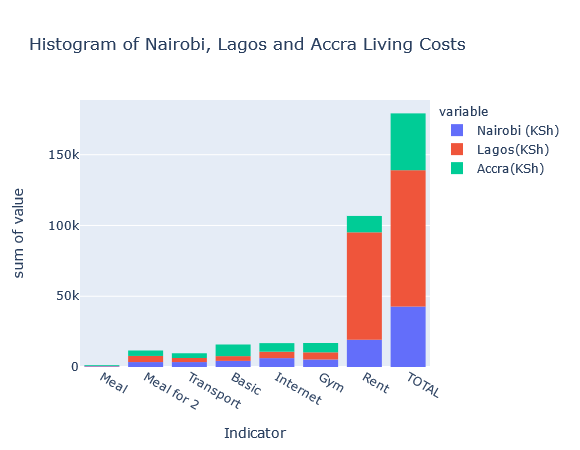

<Figure size 1440x432 with 0 Axes>

In [72]:
# Create approprite dataframes with price and percent difference columns seeperated
df_price = livingCost[['Nairobi (KSh)', 'Lagos(KSh)', 'Accra(KSh)']]
df_diff = livingCost[['NairobiLagos(%)', 'NairobiAccra(%)']]

# Plot the figure

# Subplot 1: Box plot
fig1= px.histogram(livingCost, x='Indicator', y=['Nairobi (KSh)', 'Lagos(KSh)', 'Accra(KSh)'], title='Histogram of Nairobi, Lagos and Accra Living Costs') 

plt.figure(figsize=(20, 6))

fig1.show()

Removing the total and rent rows to get a better view of the individual changes:

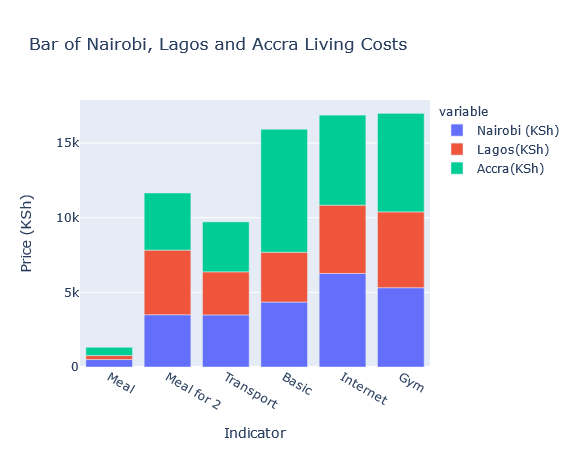

In [79]:
df_price = livingCost[:6]
priceFig= px.bar(df_price, x='Indicator', y=['Nairobi (KSh)', 'Lagos(KSh)', 'Accra(KSh)'], title='Bar of Nairobi, Lagos and Accra Living Costs') 
priceFig.update_layout(xaxis_title='Indicator', yaxis_title='Price (KSh)')
priceFig.show()

From this it can be seen that the rent in Lagos largely contributes to the high cost of living. The next plot showin the indicator percent difference further highlights this.

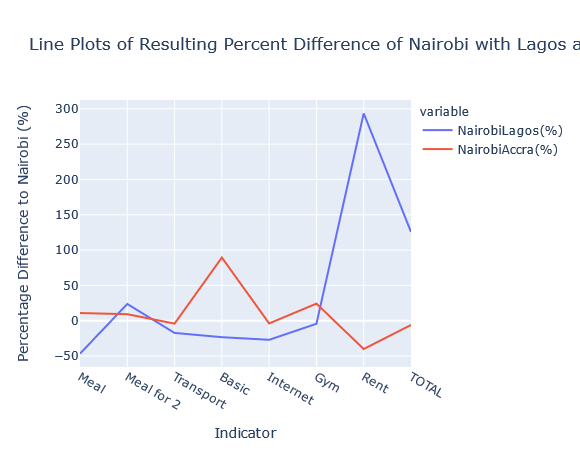

In [80]:
indFig= px.line(livingCost, x='Indicator', y=['NairobiLagos(%)', 'NairobiAccra(%)'], title='Line Plots of Resulting Percent Difference of Nairobi with Lagos and Accra')
indFig.update_layout(xaxis_title='Indicator', yaxis_title='Percentage Difference to Nairobi (%)')
indFig.show()

Following the cost of living analysis, the next section will focus on recreational opportunities.

### Foursquare Data
In this section, a surface level analysis will be applied to the filtered venue data. Getting a feel of the categories, each category shall be counted and displayed before the removal of venues with missing data.


Starting off with Nairobi data, find the unique categories and record their frequency.

In [90]:
nairobi_filtered.groupby('categories')
naiCat = nairobi_filtered['categories'].unique()
naiCatCount = list(nairobi_filtered.categories.value_counts())
nairobiCategories= pd.DataFrame({'Category': naiCat, 'Frequency':naiCatCount})
print("The number of unique categories found in these 500 venues is: {}".format(len(naiCat)))

The number of unique categories found in these 500 venues is: 31


As there are 31 unique values, these will be sort by frequency to get the top 5 venue types.

In [93]:
nairobiCategories.sort_values(by ='Frequency')# Sort
nairobiCategories.head()# Get top 5

,Category,Frequency
0,Gym,4
1,Post Office,4
2,Chinese Restaurant,4
3,Lounge,3
4,BBQ Joint,2


The same steps have been repeated for Accra and Lagos:

In [100]:
accra_filtered.groupby('categories')
accCat = accra_filtered['categories'].unique()
accCatCount = list(accra_filtered.categories.value_counts())
accraCategories= pd.DataFrame({'Category': accCat, 'Frequency':accCatCount})
print("The number of unique categories found in these 500 venues in ACCRA is: {}".format(len(accCat)))

The number of unique categories found in these 500 venues in ACCRA is: 31


In [99]:
accraCategories.sort_values(by ='Frequency')# Sort
accraCategories.head()# Get top 5

,Category,Frequency
0,Hotel,4
1,Plaza,4
2,Other Great Outdoors,3
3,Lounge,3
4,Bar,3


In [101]:
lagos_filtered.groupby('categories')
lagCat = lagos_filtered['categories'].unique()
lagCatCount = list(lagos_filtered.categories.value_counts())
lagosCategories= pd.DataFrame({'Category': lagCat, 'Frequency':lagCatCount})
print("The number of unique categories found in these 500 venues in LAGOS is: {}".format(len(lagCat)))

The number of unique categories found in these 500 venues in LAGOS is: 29


In [103]:
lagosCategories.sort_values(by ='Frequency')# Sort
lagosCategories.head()# Get top 5

,Category,Frequency
0,Soccer Field,6
1,Bridge,4
2,BBQ Joint,3
3,African Restaurant,3
4,Fried Chicken Joint,2


At this point of the data science methodology, the initial broad categories from Foursquare API would be further specified by going one level down in the categories tree and identifying ideal entertainment and fun venues. Luckily, a function was created for this step and so a rerun would not be too much of a hassle. With *Arts and Entertainment* and *Nightlife* being the main focus and the restaurant data being seperated, the process is repeated.

In [113]:
# Define URL
longitude =lonGh
latitude = latGH
radius = 7500
urlVen = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06376d81259&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, radius, LIMIT)
urlfood = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, radius, LIMIT)

# Get dataframe
accra_filtered =  getVenues(urlVen)
accra_Restaurant =  getVenues(urlfood)
accra_map= cityMap(latitude, longitude, accra_Restaurant)
accra_filtered.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



,name,categories,address,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,crossStreet,postalCode,id
0,Kempinski Executive Lounge,Lounge,Gamel Abdul Nasser Ave,5.554642,-0.197803,"[{'label': 'display', 'lat': 5.554642, 'lng': ...",183,GH,Accra,Greater Accra Region,Ghana,"[Gamel Abdul Nasser Ave, Accra, Ghana]",NaN,NaN,5b96cab8b77c77002c8a3c00
1,Black Star Square,Historic Site,NaN,5.548006,-0.192508,"[{'label': 'display', 'lat': 5.548005712763101...",1016,GH,Accra,Greater Accra Region,Ghana,"[Accra, Ghana]",NaN,NaN,50ea7c68e4b07c15c8291675
2,National Theatre,General Entertainment,NaN,5.554857,-0.200591,"[{'label': 'display', 'lat': 5.554857044338629...",428,GH,Accra,Greater Accra Region,Ghana,"[Accra, Ghana]",NaN,NaN,4db07a7dcda14b702a31f660
3,Twist,Lounge,Abafun Crescent,5.571706,-0.167054,"[{'label': 'display', 'lat': 5.571706158277336...",3739,GH,Accra Metropolis,Greater Accra Region,Ghana,"[Abafun Crescent, Accra Metropolis, Ghana]",NaN,NaN,4baa8b4ff964a52047733ae3
4,Vienna City,Casino,Accra,5.566276,-0.214540,"[{'label': 'display', 'lat': 5.566275569590284...",2263,GH,Accra,Greater Accra Region,Ghana,"[Accra, Accra, Ghana]",NaN,NaN,4f1b382ee4b0d9f8b923cf12


In [105]:
accra_filtered.groupby('categories')
accCat = accra_filtered['categories'].unique()
accCatCount = list(accra_filtered.categories.value_counts())
accraCategories= pd.DataFrame({'Category': accCat, 'Frequency':accCatCount})
print("The number of unique categories found in these 500 venues in ACCRA is: {}".format(len(accCat)))

The number of unique categories found in these 500 venues in ACCRA is: 23


In [106]:
accraCategories.sort_values(by ='Frequency')# Sort
accraCategories.head()# Get top 5

,Category,Frequency
0,Lounge,10
1,Historic Site,6
2,General Entertainment,4
3,Bar,3
4,Office,2


In [114]:
# Define URL
longitude =lonNG
latitude = latNG
radius = 17000
urlVen = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06376d81259&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, radius, LIMIT)
urlfood = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, radius, LIMIT)

# Get dataframe
lagos_filtered = getVenues(urlVen)
lagos_Restaurant =  getVenues(urlfood)
lagos_map= cityMap(latitude, longitude, lagos_Restaurant)
lagos_filtered.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



,name,categories,address,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,postalCode,neighborhood,crossStreet,id
0,Muson Centre,Convention Center,Onikan,6.443333,3.401084,"[{'label': 'display', 'lat': 6.443332659885113...",1389,NG,Lagos,Lagos,Nigeria,"[Onikan, Lagos, Lagos, Nigeria]",NaN,NaN,NaN,4c57462a7613b7132e1b91ea
1,Tennis Court 1004 Estate,Tennis Court,NaN,6.439582,3.432510,"[{'label': 'display', 'lat': 6.439582, 'lng': ...",4485,NG,Lagos,Lagos,Nigeria,"[Lagos, Lagos, Nigeria]",NaN,NaN,NaN,5dbed282e9b1a00008724bda
2,National theater,Art Gallery,Iganmu,6.479552,3.367335,"[{'label': 'display', 'lat': 6.479552339085854...",4145,NG,Lagos,Lagos,Nigeria,"[Iganmu, Lagos 23401, Lagos, Nigeria]",23401,Lagos Mainland,NaN,4c377964ae2da5934bf3fec5
3,7.11,Bar,Grandview Plaza,6.618902,3.381126,"[{'label': 'display', 'lat': 6.618901700714298...",18409,NG,Magodo GRA,NaN,Nigeria,"[Grandview Plaza, Magodo GRA, Nigeria]",NaN,NaN,NaN,4f930c4ae4b020d1a2fd3504
4,Liquid Hub,Lounge,NaN,6.448353,3.430363,"[{'label': 'display', 'lat': 6.448352758954853...",3999,NG,Lagos,Lagos,Nigeria,"[Lagos, Lagos, Nigeria]",NaN,NaN,NaN,56ae6393498eed4822fca18d


In [108]:
lagos_filtered.groupby('categories')
lagCat = lagos_filtered['categories'].unique()
lagCatCount = list(lagos_filtered.categories.value_counts())
lagosCategories= pd.DataFrame({'Category': lagCat, 'Frequency':lagCatCount})
print("The number of unique categories found in these 500 venues in LAGOS is: {}".format(len(lagCat)))

The number of unique categories found in these 500 venues in LAGOS is: 18


In [109]:
lagosCategories.sort_values(by ='Frequency')# Sort
lagosCategories.head()# Get top 5

,Category,Frequency
0,Convention Center,15
1,Tennis Court,6
2,Lounge,4
3,Nightclub,4
4,Cocktail Bar,3


In [115]:
# Define URL
longitude =lonKE
latitude = latKE
radius = 14900
urlVen = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06376d81259&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, radius, LIMIT)
urlfood = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, radius, LIMIT)

# Get dataframe
nairobi_filtered =  getVenues(urlVen)
nairobi_Restaurant =  getVenues(urlfood)
nairobi_map= cityMap(latitude, longitude, nairobi_Restaurant)
nairobi_filtered.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



,name,categories,address,lat,lng,labeledLatLngs,distance,cc,neighborhood,city,state,country,formattedAddress,crossStreet,postalCode,id
0,GPO,Post Office,Kenyatta Avenue,-1.286062,36.818532,"[{'label': 'display', 'lat': -1.28606233636563...",368,KE,City Square,Nairobi,Nairobi,Kenya,"[Kenyatta Avenue, Nairobi, Kenya]",NaN,NaN,4e1970d87d8b8af913973f43
1,Muringa Pub,Pub,NaN,-1.282972,36.826675,"[{'label': 'display', 'lat': -1.2829721, 'lng'...",1114,KE,NaN,Nairobi,Nairobi,Kenya,"[Nairobi, Kenya]",NaN,NaN,585e4d68469aef7d53a389a2
2,The Bar Next Door,Bar,Othaya Road,-1.287406,36.772780,"[{'label': 'display', 'lat': -1.2874063, 'lng'...",4905,KE,NaN,Nairobi,Nairobi,Kenya,"[Othaya Road, Nairobi, Kenya]",NaN,NaN,5ff9d845b2918871850c1d79
3,Smuff Whiskey Bar & Grill,Whisky Bar,NaN,-1.235698,36.873980,"[{'label': 'display', 'lat': -1.2356981, 'lng'...",8294,KE,NaN,Nairobi,Nairobi,Kenya,"[Nairobi, Kenya]",NaN,NaN,5ada45d8bf7dde53c5dc3b72
4,Winning Post,Lounge,NaN,-1.311537,36.742291,"[{'label': 'display', 'lat': -1.311537, 'lng':...",8853,KE,NaN,NaN,NaN,Kenya,[Kenya],NaN,NaN,5fe86cea45ffa21fad22d02e


In [111]:
nairobi_filtered.groupby('categories')
naiCat = nairobi_filtered['categories'].unique()
naiCatCount = list(nairobi_filtered.categories.value_counts())
nairobiCategories= pd.DataFrame({'Category': naiCat, 'Frequency':naiCatCount})
print("The number of unique categories found in these 500 venues is: {}".format(len(naiCat)))

The number of unique categories found in these 500 venues is: 21


In [112]:
nairobiCategories.sort_values(by ='Frequency')# Sort
nairobiCategories.head()# Get top 5

,Category,Frequency
0,Post Office,11
1,Pub,11
2,Bar,6
3,Lounge,4
4,Whisky Bar,2


Well Nairobi seems to have a lot of post offices, can come in handy if moving to the West entails sending gifts. From brief inspection, the categories for some of these venues are a bit curious. Comparing the results however, Ghana seems to have a similar recreational categoriy distribution as Nairobi, with the most unique categories. The final thing to do will be an analysis of the restaurants in each city,can you guess the top restaurant category?

In [ ]:
# If further analysis is done, drop these columns.
# ['name', 'categories' , 'lat' , 'lng' , 'labeledLatLngs' , 'distance' , 'neighborhood', 'address']

In a similar order, the top 5 restaurant categories will be displayed and a map for visualization created.

In [116]:
# Dizplay Restaurant Map of Accra
accra_map

In [118]:
# Get top 5 categories [Accra]
accra_Restaurant.groupby('categories')
accCat = accra_Restaurant['categories'].unique()
accCatCount = list(accra_Restaurant.categories.value_counts())
accraCategories= pd.DataFrame({'Category': accCat, 'Frequency':accCatCount})
#print("The number of unique categories found in these 500 venues in ACCRA is: {}".format(len(accCat)))
accraCategories.sort_values(by ='Frequency')# Sort
accraCategories.head()# Get top 5

,Category,Frequency
0,Hotel,7
1,Chinese Restaurant,5
2,Breakfast Spot,4
3,Theme Restaurant,4
4,Fast Food Restaurant,4


In [119]:
# Dizplay Restaurant Map of Lagos
lagos_map

In [120]:
# Get top 5 categories [Lagos]
lagos_Restaurant.groupby('categories')
lagCat = lagos_Restaurant['categories'].unique()
lagCatCount = list(lagos_Restaurant.categories.value_counts())
lagosCategories= pd.DataFrame({'Category': lagCat, 'Frequency':lagCatCount})
#print("The number of unique categories found in these 500 venues in LAGOS is: {}".format(len(lagCat)))
lagosCategories.sort_values(by ='Frequency')# Sort
lagosCategories.head()# Get top 5

,Category,Frequency
0,Fast Food Restaurant,8
1,BBQ Joint,7
2,African Restaurant,4
3,Restaurant,4
4,Hotel Bar,2


In [121]:
# Dizplay Restaurant Map of Nairobi
nairobi_map

In [122]:
# Get top 5 categories [Nairobi]
nairobi_Restaurant.groupby('categories')
naiCat = nairobi_Restaurant['categories'].unique()
naiCatCount = list(nairobi_Restaurant.categories.value_counts())
nairobiCategories= pd.DataFrame({'Category': naiCat, 'Frequency':naiCatCount})
#print("The number of unique categories found in these 500 venues is: {}".format(len(naiCat)))
nairobiCategories.sort_values(by ='Frequency')# Sort
nairobiCategories.head()# Get top 5

,Category,Frequency
0,Coffee Shop,8
1,Fish & Chips Shop,6
2,Chinese Restaurant,4
3,BBQ Joint,4
4,Bakery,3


## Results and Discussion <a name="results"></a>

Looking at the percent increase in the cost of living, although Accra has a **89.42%** increase in utilities for *Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment*, the **293.58%** increase in Rent for *Lagos* makes it difficult to compare. This might be due to the high population density of the city, factoring in its notoriious traffic and larger opportunities in its entertainment industry the stakeholder would have a difficult decision at hand.

And this is where the possibility of opening a restaurant, and overall personal fun and recreation comes in play. An in-depth analysis using clustering will be done in future studies. This sectiion however did highlight a loop back required during the analysis, highlighting the need for agile solutions.

Looking at the Restaurant data was a bit interesting, let me guess your original most popular category was **African restaurant** right? interestingly enough, Lagos was the only place that had that in its top 5. Bare in mind these are all African cities, but for opening a restaurant the stakeholder has a choice. Accra presents it as not so popular, for a staeholder looking for minimal competition that might be a good start.Lagoson the other hand seems to have a demand **(having African restaurants in an African city is not much of a qualifier as those counted might be all Nigerian/West African)**

*A biased aside, choose Lagos if only for the Jollof!*

## Conclusion <a name="conclusion"></a>

The purpose of this capstone project was to compare major African cities in the quest for finding a place like home, witth a possibility of adding to the city's multicultural restaurant scene. From the preliminary analysis, the cost of living in Accra compared to Nairobi is a little lower; however living in Lagos is almost twice as expensive although it might have more growth opportunities entertainment-wise.


As previously stated, the test set used in this analysis was not much as the data available and number of participants were not enough for a deeper analysis. Future considerations of this project would be to build on this initial analysis using a greater data source range. Google's API would be a good place to get location data as well and the cost can be overlooked for a more in-depth analysis.

# REFERENCES <a name="references"></a>
1. [Numbeo](https://www.numbeo.com/cost-of-living/compare_cities.jsp?country1=Kenya&country2=Ghana&city1=Nairobi&city2=Accra)
2. [Foursquare API Categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/)
3. [Latitude Longitude Org](https://latitudelongitude.org/gh/accra/)
